In [2]:
import numpy as np 
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

# for the persistence diagrams and the betti numbers
import scipy as sp
from matplotlib import cm
import ripser
import persim

# for the persistence landscape
from persim import PersLandscapeApprox, PersLandscapeExact
from persim.landscapes import plot_landscape_simple

# for running the code faster
import multiprocessing as mp

In [3]:
import os
import multiprocessing

cpu_count = os.cpu_count()
cpu_count_mp = multiprocessing.cpu_count()

print(f"Number of CPUs (logical cores): {cpu_count}")
print(f"Number of CPUs (multiprocessing): {cpu_count_mp}")

Number of CPUs (logical cores): 32
Number of CPUs (multiprocessing): 32


# Persistent Homology
1. Turn distance matrices into a Rips filtration
2. Look at the Betti numbers for the formations of holes and voids near/during a crash
3. Try characterizing the change in shape with persistence landscapes.

This code is for accessing the data.

In [6]:
filepath = 'matrices/110 2023-09-25 00:00:00.pickl'
with open(filepath, 'rb') as f:
    file = pickle.load(f)
file

{'PSE log returns': array([[            nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan,             nan, -1.84620628e-02,
                     nan,             nan,             nan,
                     nan,             nan,             nan,
         -8.55672221e-02,             nan,             nan,
                     nan,             nan,             nan,
                     nan,  6.92044284e-03,             nan,
          1.53253278e-02,             nan,  6.93147181e-01,
                     nan,             nan,             nan,
                     nan,             nan,             nan,
         -8.11912444e-03,             nan,             nan,
                     nan,             nan,             nan,
                     nan,             nan,             nan,
          3.17486983e-02,             nan,             nan,
                     

Distance matrix of 110 2013-09-26 00_00_00.pickl


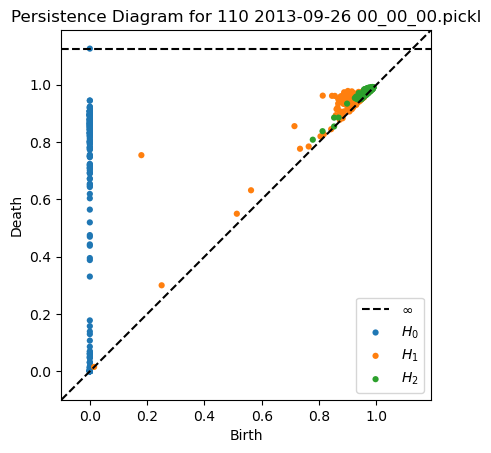

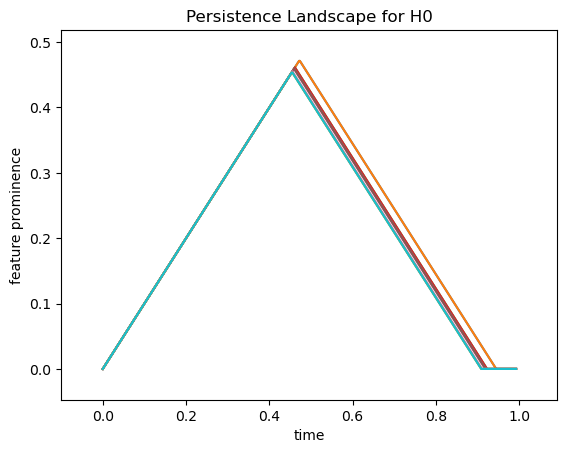

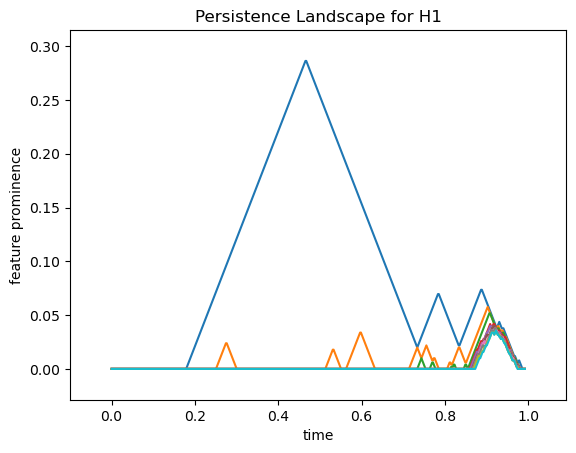

Distance matrix of 110 2018-01-30 00_00_00.pickl


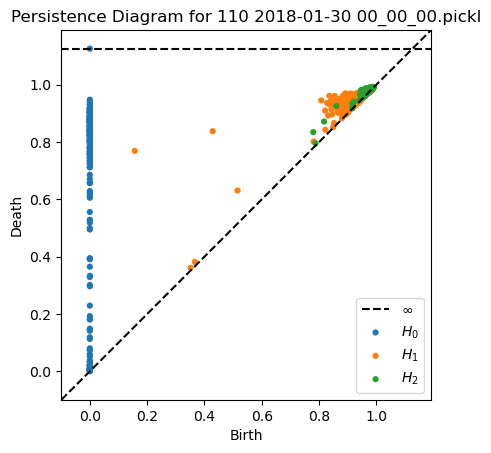

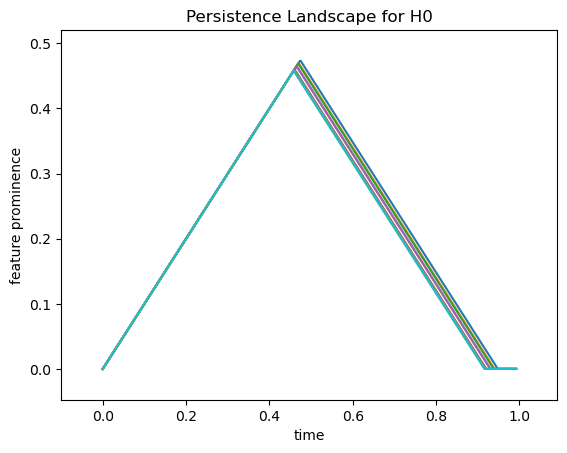

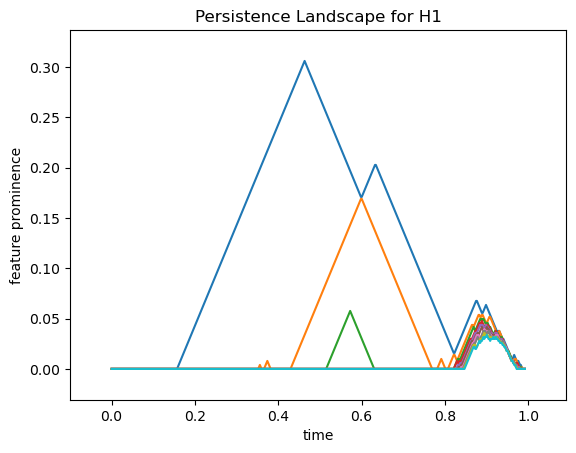

Distance matrix of 110 2020-12-04 00_00_00.pickl


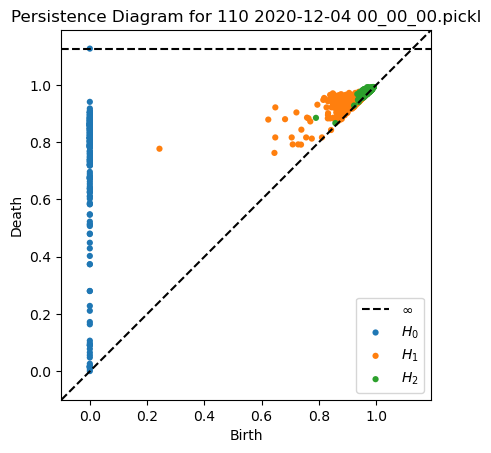

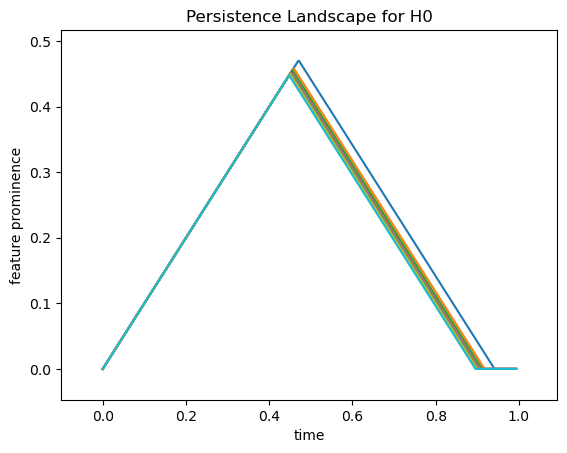

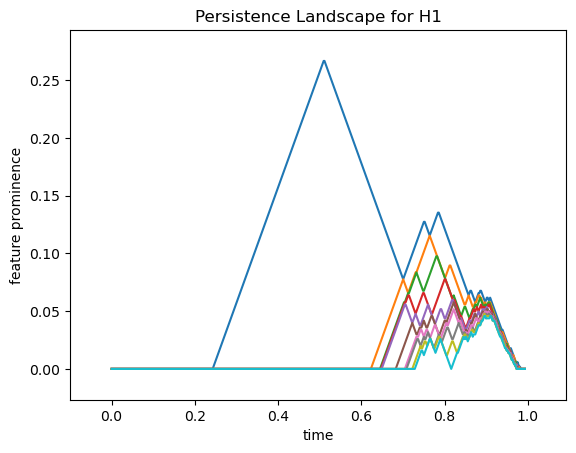

Distance matrix of 110 2022-08-22 00_00_00.pickl


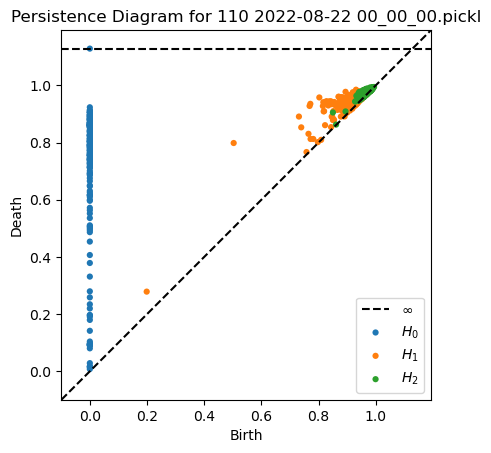

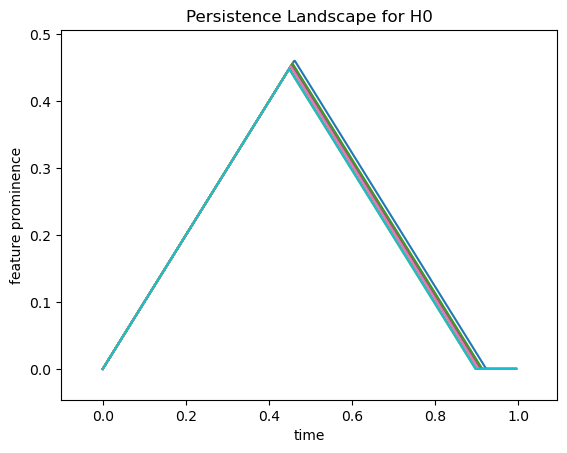

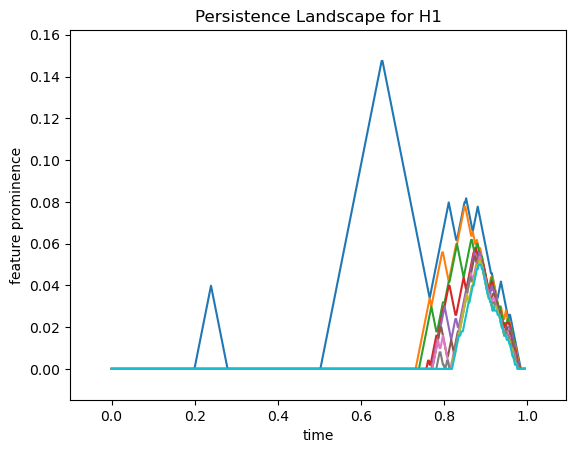

Distance matrix of 110 2023-09-25 00_00_00.pickl


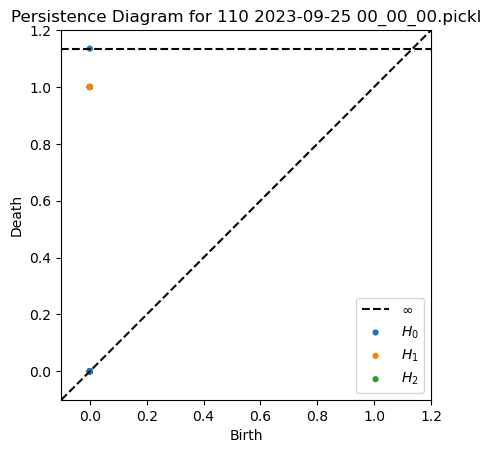

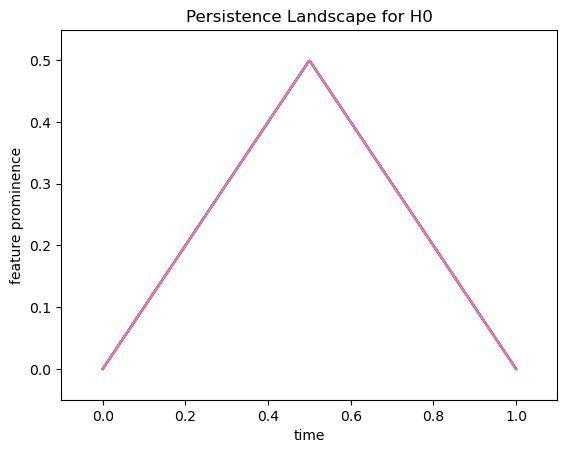

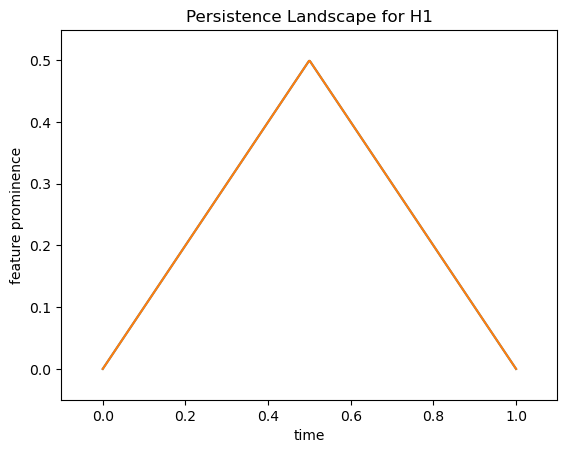

In [5]:
directory = r"trial_matrices"
betti_df = pd.DataFrame(columns=["\u03B20", "\u03B21", "\u03B22"])
plot_directory = r"pers_hom"

for name in sorted(os.listdir(directory)):
    file_path = os.path.join(directory, name)
    
    if os.path.isfile(file_path) and name.endswith('.pickl'):
        try:
            with open(file_path, 'rb') as f:
                print(f"Distance matrix of {name}")
                data = pickle.load(f)
                dist_matrix = data.get('distance matrix')
                if dist_matrix is None:
                    print(f"Distance matrix not found in {name}")
        except (pickle.UnpicklingError, EOFError, KeyError) as e:
            print(f"Error loading {name}: {e}")
            continue
    
    # this is for making a persistence diagram from a rips filtration 
    pers_diag = ripser.ripser(dist_matrix, distance_matrix=True, maxdim=2)
    diagrams = pers_diag['dgms']
    
    fig, ax = plt.subplots()
    persim.plot_diagrams(diagrams, ax=ax)
    plt.title(f'Persistence Diagram for {name}')
    plt.show()
    
    # # This is to save the persistence diagram
    # diagram_path = os.path.join(plot_directory, f"{name}_persistence_diagram.png")
    # plt.savefig(diagram_path, dpi=300, bbox_inches='tight')
    # plt.close(fig) 
    
    # this is to get the betti numbers
    # Note: will edit this to have more betti numbers later
    betti_0 = sum(d[1] == np.inf for d in diagrams[0]) if len(diagrams) > 0 else 0
    betti_1 = len(diagrams[1]) if len(diagrams) > 1 else 0 
    betti_2 = len(diagrams[2]) if len(diagrams) > 2 else 0 
    
    new_row = pd.DataFrame({"\u03B20": [betti_0], 
                            "\u03B21": [betti_1], 
                            "\u03B22": [betti_2]
                           }, index=[name])
    betti_df = pd.concat([betti_df, new_row], ignore_index=True)
    
    # this is to get the persistence landscape
    for dim in range(2):
        filtered_diagrams = [d for d in diagrams if len(d) > 0]

        min_birth, max_death = (
            min((p[0] for d in diagrams if len(d) > 0 for p in d), default=float("inf")),
            max((p[1] for d in diagrams if len(d) > 0 for p in d if p[1] != np.inf), default=float("-inf"))
        )

        if dim >= len(diagrams) or len(diagrams[dim]) == 0:
            print(f"Skipping persistence landscape for H{dim} (empty diagram)")
            continue 
        
        pla = PersLandscapeApprox(dgms=diagrams, hom_deg=dim, start=min_birth, stop=max_death)
        
        fig, ax = plt.subplots()
        ax = plot_landscape_simple(pla, depth_range=range(10))
        plt.xlabel('time')
        plt.ylabel('feature prominence')
        plt.title(f'Persistence Landscape for H{dim}')
        plt.legend().set_visible(False)
        plt.show()

        # # This is to save the persistence landscape
        # landscape_path = os.path.join(plot_directory, f"{name}_H{dim}_landscape.png")
        # plt.savefig(landscape_path, dpi=300, bbox_inches='tight')
        # plt.close(fig)

betti_df.to_pickle("betti_df.pkl") 